LiDAR data shape: (317, 117)
RAP data shape: (317, 117)
NDVI Metadata:
Driver: GTiff
Width: 1053
Height: 1149
Number of bands: 38
Coordinate Reference System: EPSG:6514
Transform: | 29.97, 0.00, 242864.02|
| 0.00,-29.97, 298323.42|
| 0.00, 0.00, 1.00|
Bounding box: BoundingBox(left=242864.01589656895, bottom=263882.77422240796, right=274427.1177912072, top=298323.4238681243)
Creating output file that is 320P x 405L.
Processing /Users/kdoherty/Downloads/46114f1/MISSOULA_2019_ClrkFrkBttrtRvr/HFDEM/46114f1_HFDEM.tif [1/1] : 0Using internal nodata values (e.g. -3.40282e+38) for image /Users/kdoherty/Downloads/46114f1/MISSOULA_2019_ClrkFrkBttrtRvr/HFDEM/46114f1_HFDEM.tif.
Copying nodata values from source /Users/kdoherty/Downloads/46114f1/MISSOULA_2019_ClrkFrkBttrtRvr/HFDEM/46114f1_HFDEM.tif to destination /tmp/dem_reprojected.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
DEM data shape: (317, 117)
Neighborhood size in pixels: 2500m=56


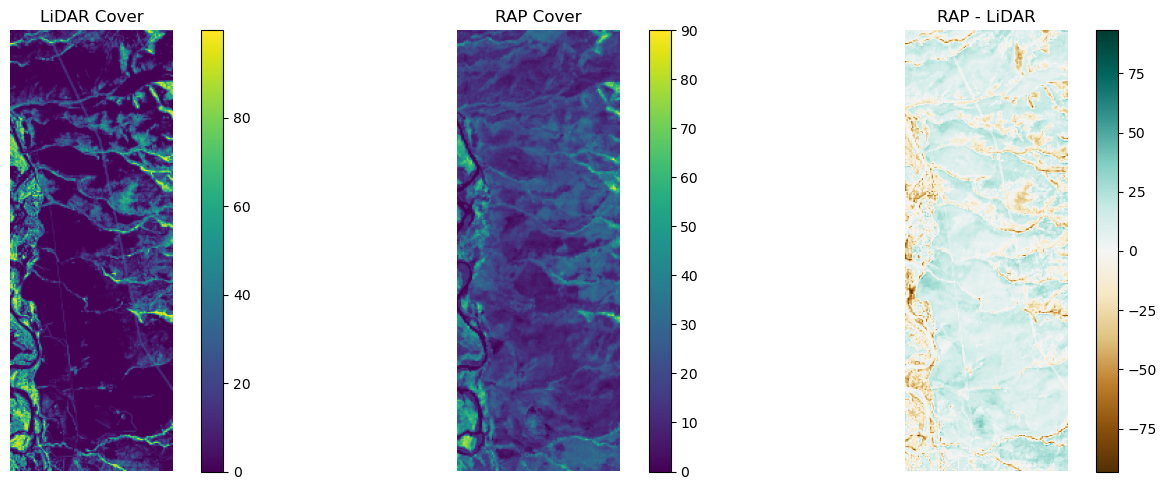

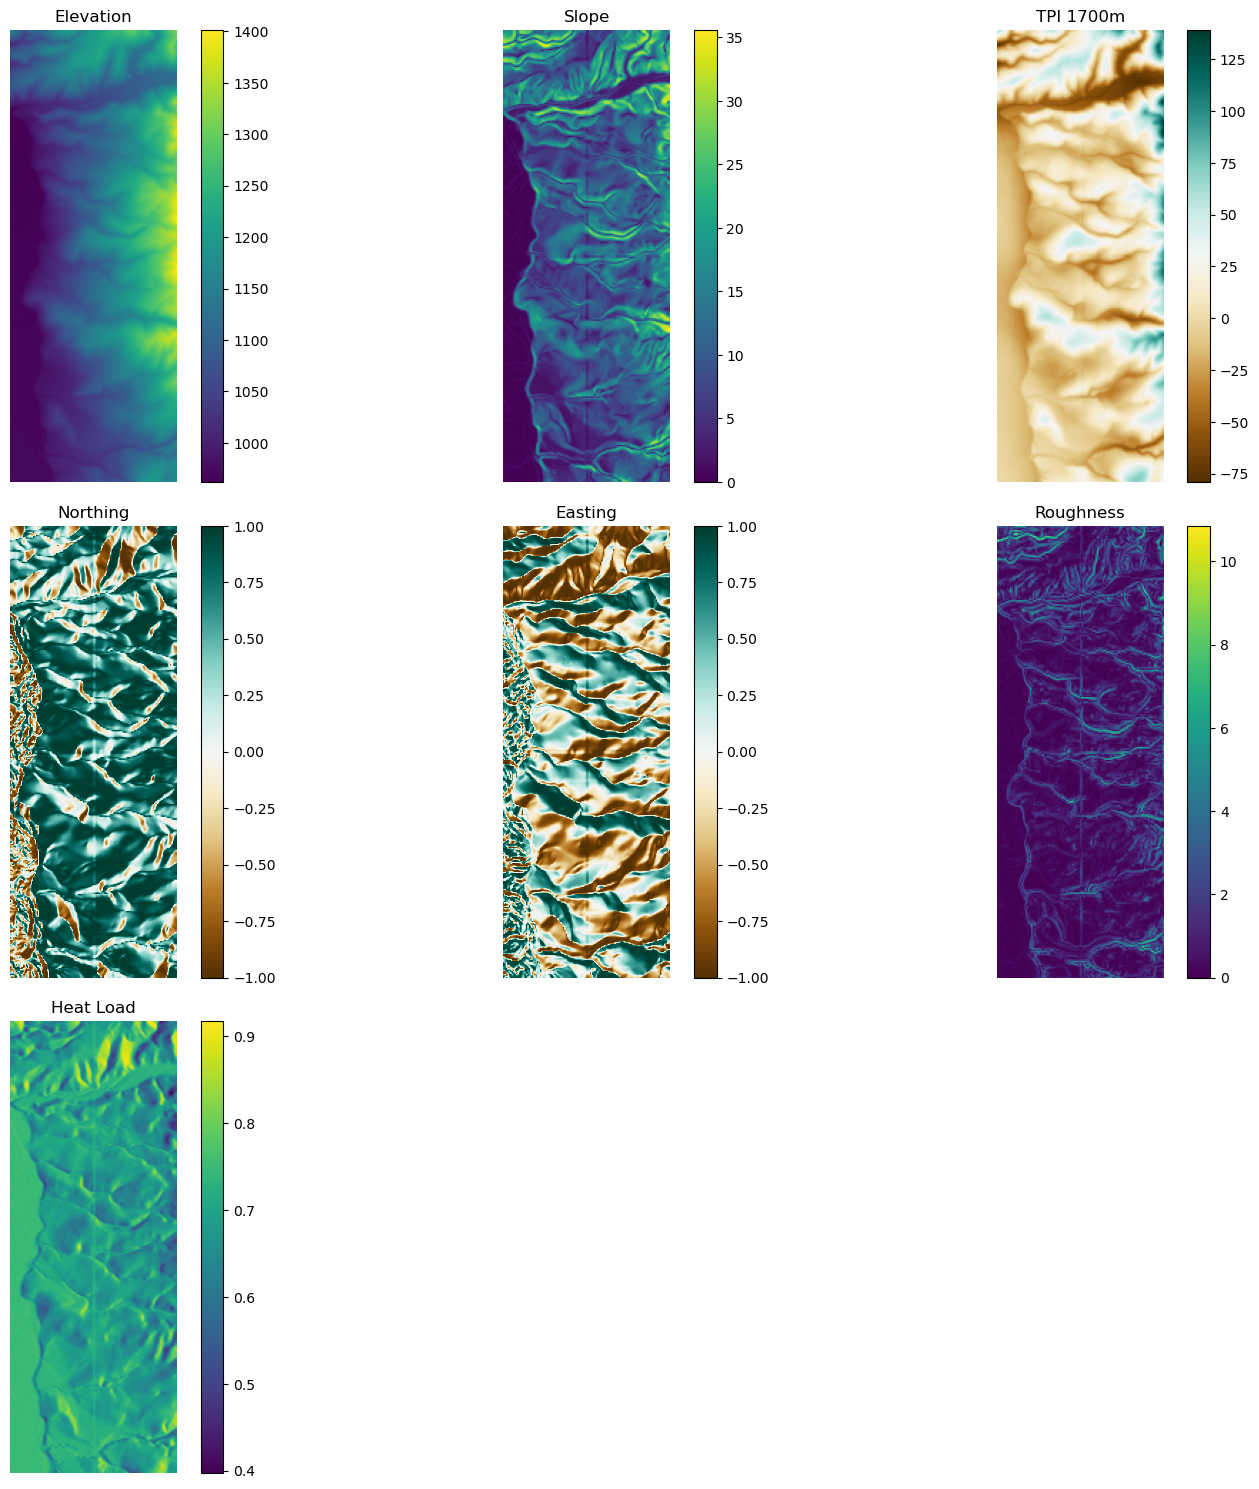

In [10]:
import rasterio
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
from scipy.ndimage import uniform_filter
import lightgbm as lgb
import subprocess
import os
import scipy.ndimage
# File paths for the raster data
lidar_cover = '/Users/kdoherty/Downloads/lidar_cover_2019.tif'
rap_cover = '/Users/kdoherty/Downloads/rap_cover_2019.tif'
dem = '/Users/kdoherty/Downloads/46114f1/MISSOULA_2019_ClrkFrkBttrtRvr/HFDEM/46114f1_HFDEM.tif'
# ndvi_path = '/Users/kdoherty/Downloads/landsat_ndvi_1984_2021_epsg6514.tif'

# Read DEM data
with rasterio.open(dem) as src:
    dem_data = src.read(1)
    nodata = src.nodata  # Get the NoData value

# Replace NoData values with np.nan
if nodata is not None:
    dem_data = np.where(dem_data == nodata, np.nan, dem_data)

upper_left = 252500,287500
bottom_right = 256000,278000

# Unpack coordinates explicitly
x1, y1 = upper_left  # upper left
x2, y2 = bottom_right  # bottom right

# Make sure coordinates are properly ordered (left < right, bottom < top)
left = min(x1, x2)
right = max(x1, x2)
bottom = min(y1, y2)
top = max(y1, y2)

# Read metadata from LiDAR cover file
with rasterio.open(lidar_cover) as src:
    lidar_meta = {
        'transform': src.transform,
        'crs': src.crs,
        'width': src.width,
        'height': src.height,
        'bounds': src.bounds
    }

# Create window with explicit ordering
window = rasterio.windows.from_bounds(
    left=left,
    bottom=bottom,
    right=right,
    top=top,
    transform=lidar_meta['transform']
)

# Load and crop RAP and LiDAR data
with rasterio.open(lidar_cover) as src:
    lidar_data = src.read(1, window=window)
    print(f"LiDAR data shape: {lidar_data.shape}")

with rasterio.open(rap_cover) as src:
    rap_data = src.read(1, window=window)
    print(f"RAP data shape: {rap_data.shape}")

# Print NDVI metadata
with rasterio.open('/Users/kdoherty/Downloads/landsat_ndvi_1984_2021_epsg6514.tif') as src:
    print("NDVI Metadata:")
    print(f"Driver: {src.driver}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Number of bands: {src.count}")
    print(f"Coordinate Reference System: {src.crs}")
    print(f"Transform: {src.transform}")
    print(f"Bounding box: {src.bounds}")

# Reproject and clip DEM
dem_reprojected_path = '/tmp/dem_reprojected.tif'
if os.path.exists(dem_reprojected_path):
    os.remove(dem_reprojected_path)

# Build gdal command to reproject DEM
gdal_cmd = [
    'gdalwarp',
    '-t_srs', lidar_meta['crs'].to_string(),
    '-tr', str(lidar_meta['transform'][0]), str(abs(lidar_meta['transform'][4])),
    '-r', 'bilinear',
    dem,
    dem_reprojected_path
]

# Execute gdal command
subprocess.run(gdal_cmd, check=True)

# Read the reprojected DEM and crop it
with rasterio.open(dem_reprojected_path) as src_dem:
    dem_reprojected = src_dem.read(1, window=window)
    print(f"DEM data shape: {dem_reprojected.shape}")

# Clean up temporary files
os.remove(dem_reprojected_path)

# Calculate Slope (in degrees)
def calculate_slope(dem, cell_size):
    # Calculate gradients in x and y directions
    dy, dx = np.gradient(dem, cell_size)
    
    # Calculate slope in degrees
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
    
    return slope

# Calculate Aspect components (Northing and Easting)
def calculate_aspect_components(dem, cell_size, latitude=46.8):
    # Calculate gradients
    dy, dx = np.gradient(dem, cell_size)
    
    # Calculate aspect in radians
    aspect = np.arctan2(dy, dx)
    
    # Calculate northing (cosine of aspect)
    northing = np.cos(aspect)
    
    # Calculate easting (sine of aspect)
    easting = np.sin(aspect)
    
    # Calculate slope
    slope = np.degrees(np.arctan(np.sqrt(dx**2 + dy**2)))
    
    # Calculate heat load
    slope_rad = np.radians(slope)
    lat_rad = np.radians(latitude)
    heat_load = 0.339 + 0.808 * np.cos(lat_rad) * np.cos(slope_rad) - \
                0.196 * np.sin(lat_rad) - 0.482 * np.cos(aspect) * np.sin(slope_rad)
    
    return northing, easting, heat_load

# Calculate TPI
def calculate_tpi(dem, neighborhood_size):
    # Calculate focal mean using uniform filter
    kernel = np.ones((neighborhood_size, neighborhood_size))
    n = kernel.sum()
    
    # Calculate mean elevation in the neighborhood
    dem_sum = uniform_filter(dem, size=neighborhood_size) * n
    dem_count = uniform_filter(np.ones_like(dem), size=neighborhood_size) * n
    
    # Avoid division by zero
    mean_elevation = np.where(dem_count > 0, dem_sum / dem_count, np.nan)
    
    # Calculate TPI
    tpi = dem - mean_elevation
    
    return tpi

def calculate_tri(dem, cell_size):
    # Calculate differences to neighboring cells
    kernel = np.array([
        [-1,-1,-1],
        [-1, 8,-1],
        [-1,-1,-1]
    ]) / 8
    tri = np.abs(scipy.ndimage.convolve(dem, kernel))
    return tri

# Calculate cell size from the transform
cell_size = lidar_meta['transform'][0]

# Calculate neighborhood size in pixels for 2500m
neighborhood_1700m = int(1700 / cell_size)

print(f"Neighborhood size in pixels: 2500m={neighborhood_1700m}")

# Perform calculations
slope = calculate_slope(dem_reprojected, cell_size)
northing, easting, heat_load = calculate_aspect_components(dem_reprojected, cell_size)
tpi_1700m = calculate_tpi(dem_reprojected, neighborhood_size=neighborhood_1700m)
tri = calculate_tri(dem_reprojected, cell_size)

# Calculate the difference between LiDAR cover and RAP cover
rap_minus_lidar = rap_data - lidar_data

# Create one figure for LiDAR, RAP, and RAP minus LiDAR
fig1, axes1 = plt.subplots(1, 3, figsize=(15, 5))

# Plot LiDAR, RAP, and RAP minus LiDAR
data_layers1 = [lidar_data, rap_data, rap_minus_lidar]
titles1 = ['LiDAR Cover', 'RAP Cover', 'RAP - LiDAR']

for i, (data, title) in enumerate(zip(data_layers1, titles1)):
    if title == 'RAP - LiDAR':
        cmap = 'BrBG'  # Divergent palette centered on 0 (red-white-blue)
        vmin, vmax = -np.max(np.abs(data)), np.max(np.abs(data))
        im = axes1[i].imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        cmap = 'viridis'  # Default palette
        im = axes1[i].imshow(data, cmap=cmap)
    axes1[i].set_title(title)
    plt.colorbar(im, ax=axes1[i])
    axes1[i].axis('off')

fig1.tight_layout()
plt.show()

# Create one figure for other variables
data_layers2 = [dem_reprojected, slope, tpi_1700m, northing, easting, tri, heat_load]
titles2 = ['Elevation', 'Slope', 'TPI 1700m', 'Northing', 'Easting', 'Roughness', 'Heat Load']

# Create only one figure with 3x3 grid
fig2, axes2 = plt.subplots(3, 3, figsize=(15, 15))
axes2 = axes2.ravel()

# Plot the 7 variables
for i, (data, title) in enumerate(zip(data_layers2, titles2)):
    if title in ['TPI 1700m', 'Northing', 'Easting']:
        cmap = 'BrBG'  # Divergent palette brown to green
        im = axes2[i].imshow(data, cmap=cmap)
    else:
        cmap = 'viridis'  # Default palette
        im = axes2[i].imshow(data, cmap=cmap)
    axes2[i].set_title(title)
    plt.colorbar(im, ax=axes2[i])
    axes2[i].axis('off')

# Remove the last two empty subplots
axes2[-1].remove()
axes2[-2].remove()

fig2.tight_layout()
plt.show()

In [45]:
import optuna
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Flatten all arrays before stacking
rap_flat = rap_data.flatten()
dem_flat = dem_reprojected.flatten()
slope_flat = slope.flatten()
northing_flat = northing.flatten()
easting_flat = easting.flatten()
lidar_flat = lidar_data.flatten()
tpi_flat = tpi_1700m.flatten()  # Use the pre-calculated TPI at 1700m
roughness_flat = tri.flatten()  # Flatten roughness data
heat_load_flat = heat_load.flatten()  # Flatten heat load data

# Create full feature matrix and target vector
X = np.column_stack((rap_flat, dem_flat, slope_flat, northing_flat, easting_flat, tpi_flat, roughness_flat, heat_load_flat))
y = lidar_flat 

# Remove rows with missing data
mask = ~(np.isnan(X).any(axis=1) | np.isnan(y) | np.isinf(X).any(axis=1) | np.isinf(y))
X = X[mask]
y = y[mask]

def objective(trial):
    params = {
        'objective': 'tweedie',
        'metric': 'mae',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 16, 32),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.3, 1.5),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 50, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 30),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-1, 1e2, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-1, 1e2, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-9, 1e-6, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-2, 10.0, log=True),
    }
    
    mae_scores = []
    for seed in range(5):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        lgb_model = lgb.LGBMRegressor(**params)
        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
    
    return np.mean(mae_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Train final model with best parameters for 5 seeds
best_params = trial.params
best_params.update({
    'objective': 'tweedie',
    'metric': 'mae',
    'n_jobs': -1
})

[I 2024-11-22 10:36:14,519] A new study created in memory with name: no-name-0432d2ff-266b-48f7-a2ad-7c0482ceaec1
[I 2024-11-22 10:37:12,565] Trial 0 finished with value: 6.155685014322293 and parameters: {'n_estimators': 1255, 'subsample': 0.9274084406446934, 'max_depth': 17, 'subsample_freq': 8, 'colsample_bytree': 0.9517350374702304, 'tweedie_variance_power': 1.4360645806555048, 'learning_rate': 0.0845872254582968, 'num_leaves': 150, 'min_child_samples': 7, 'reg_alpha': 7.160776035895611, 'reg_lambda': 0.4594406747207642, 'min_split_gain': 7.23280393629245e-08, 'min_child_weight': 0.03972349834424084}. Best is trial 0 with value: 6.155685014322293.
[I 2024-11-22 10:37:33,970] Trial 1 finished with value: 6.2550390042280934 and parameters: {'n_estimators': 718, 'subsample': 0.9550294687751975, 'max_depth': 23, 'subsample_freq': 6, 'colsample_bytree': 0.9728733426865805, 'tweedie_variance_power': 1.4653316731307766, 'learning_rate': 0.10079689980899534, 'num_leaves': 104, 'min_child_s

Best trial:
  Value:  6.0619316467135995
  Params: 
    n_estimators: 1263
    subsample: 0.9157851663348188
    max_depth: 20
    subsample_freq: 4
    colsample_bytree: 0.9888522999635124
    tweedie_variance_power: 1.4765409122081512
    learning_rate: 0.0525292221293062
    num_leaves: 131
    min_child_samples: 2
    reg_alpha: 22.455502050459877
    reg_lambda: 0.9933084030956245
    min_split_gain: 5.3239660130204525e-08
    min_child_weight: 1.4170179934154306


In [46]:
# Plot optimization history
optuna.visualization.plot_optimization_history(study)


In [47]:
# Plot optimization history# Plot slice plots
optuna.visualization.plot_slice(study)


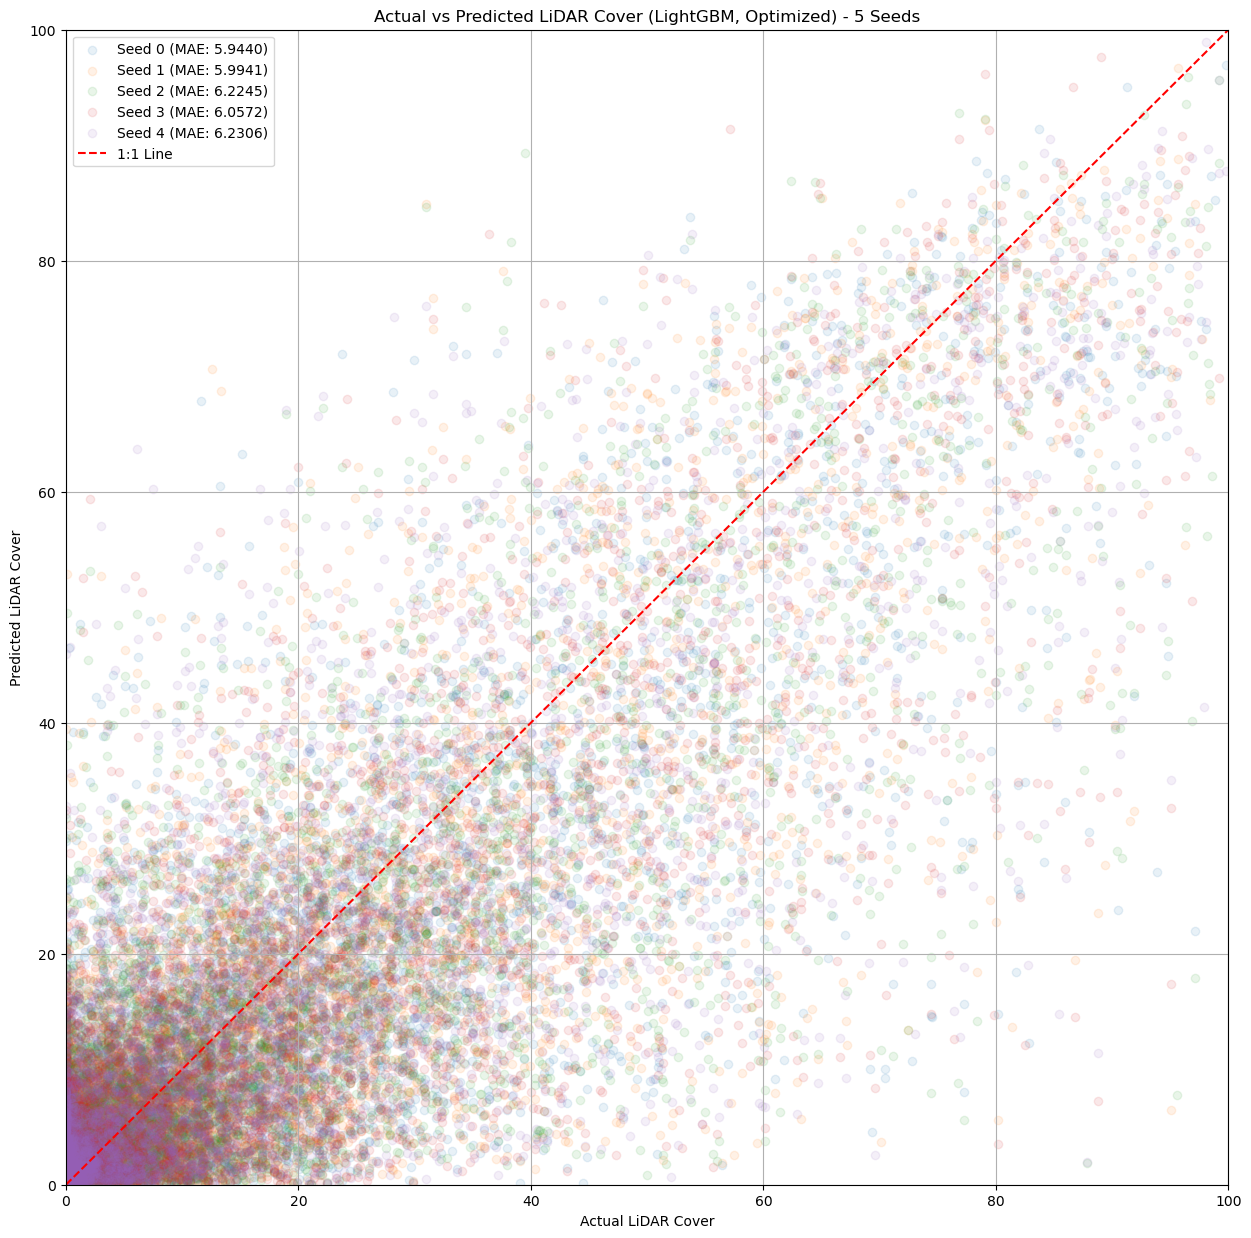

In [48]:
plt.figure(figsize=(15, 15))

for seed in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    lgb_model = lgb.LGBMRegressor(**best_params, random_state=seed)
    lgb_model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lgb_model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plot actual vs predicted values
    plt.scatter(y_test, y_pred, alpha=0.1, label=f'Seed {seed} (MAE: {mae:.4f})')

plt.plot([0, 100], [0, 100], 'r--', label='1:1 Line')
plt.xlabel('Actual LiDAR Cover')
plt.ylabel('Predicted LiDAR Cover')
plt.title('Actual vs Predicted LiDAR Cover (LightGBM, Optimized) - 5 Seeds')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Fit production model on full dataset
print("\nFitting production model on full dataset...")
# Get parameters from best trial
lgb_model_production = lgb.LGBMRegressor(
    **trial.params,
    random_state=42
)

# Calculate TPI with best neighborhood size for full dataset
best_neighborhood_pixels = int(1700 / cell_size)  # Changed from 2500 to 1700
best_tpi_full = calculate_tpi(dem_reprojected, neighborhood_size=best_neighborhood_pixels)
best_tpi_flat = best_tpi_full.flatten()

# Create feature matrix for full dataset using best TPI
column_names = ['rap', 'dem', 'slope', 'northing', 'easting', 'tpi', 'roughness', 'heat_load']
X_full = np.column_stack((rap_flat, dem_flat, slope_flat, northing_flat, easting_flat, tpi_flat, roughness_flat, heat_load_flat))
y_full = lidar_flat  # Use lidar data as target

# Remove rows with missing data
mask = ~(np.isnan(X_full).any(axis=1) | np.isnan(y_full) | np.isinf(X_full).any(axis=1) | np.isinf(y_full))
X_full = X_full[mask]
y_full = y_full[mask]

# Fit the production model
lgb_model_production.fit(X_full, y_full)

# Update the model used for prediction
lgb_model = lgb_model_production

print("Production model fitted on full dataset")

# Predict using the model for the entire raster
X_predict = X_full

# Create a mask for valid data
valid_mask = ~np.isnan(X_full).any(axis=1)

# Apply the mask to X_predict
X_predict_valid = X_predict[valid_mask]

# Predict only for valid data
predicted_lidar_valid = lgb_model.predict(X_predict_valid)

# Create a full-sized array filled with NaN
predicted_lidar = np.full(rap_data.shape, np.nan).flatten()

# Fill in the predictions for valid data
predicted_lidar[valid_mask] = predicted_lidar_valid

# Reshape back to the original shape
predicted_lidar = predicted_lidar.reshape(rap_data.shape)

# Save the predicted raster
# with rasterio.open('/Users/kdoherty/Downloads/predicted_lidar_cover_lgb.tif', 'w', **profile) as dst:
#     dst.write(predicted_lidar, 1)

print("\nScatter plot saved as 'actual_vs_predicted_lidar_scatter_lgb.png'")

# Plot regular feature importance values
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='split')
plt.title('Feature Importance (Regular)')
plt.tight_layout()
plt.savefig('/Users/kdoherty/Downloads/feature_importance_regular.png')
plt.close()

print("Feature importance plot saved as 'feature_importance_regular.png'")



Fitting production model on full dataset...
Production model fitted on full dataset

Scatter plot saved as 'actual_vs_predicted_lidar_scatter_lgb.png'
Feature importance plot saved as 'feature_importance_regular.png'


<Figure size 1000x600 with 0 Axes>

In [50]:
# Create a figure with three subplots in one row
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5))

# Add overall title
fig.suptitle('RAP Woody Cover Preliminary Calibration Efforts (2019)', fontsize=12, y=0.975)

# Plot LiDAR cover
im1 = ax1.imshow(lidar_data, cmap='viridis', vmax=50)
ax1.set_title('LiDAR Cover')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot predicted LiDAR cover
im2 = ax2.imshow(predicted_lidar, cmap='viridis', vmax=50)
ax2.set_title('Predicted LiDAR Cover')
ax2.set_xticks([])
ax2.set_yticks([])

# Plot RAP cover
im3 = ax3.imshow(rap_data, cmap='viridis', vmax=50)
ax3.set_title('RAP Cover')
ax3.set_xticks([])
ax3.set_yticks([])
cbar3 = plt.colorbar(im3, ax=ax3)
cbar3.ax.set_yticklabels([f'{int(t)}' if t < 50 else '50+' for t in cbar3.get_ticks()])
cbar3.ax.set_ylabel('Cover (%)')

# Adjust layout and display
plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('/Users/kdoherty/Downloads/cover_comparison.png')
plt.close()

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_33113/1518663549.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [51]:
# Calculate differences
pred_vs_lidar = predicted_lidar - lidar_data
rap_vs_lidar = rap_data - lidar_data

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Add overall title at the top
fig.suptitle('Differences in Cover Estimates', fontsize=16, y=0.95)

# Plot predicted vs actual LiDAR difference
im1 = ax1.imshow(pred_vs_lidar, cmap='BrBG', vmin=-25, vmax=25)
ax1.set_title('Difference Between\nPredicted and Actual\nLiDAR Cover')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot RAP vs LiDAR difference 
im2 = ax2.imshow(rap_vs_lidar, cmap='BrBG', vmin=-25, vmax=25)
ax2.set_title('Difference Between\nRAP and LiDAR Cover')
ax2.set_xticks([])
ax2.set_yticks([])

# Add a single colorbar on the right, but nudged to the left
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Adjusted from 0.92 to 0.91
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label('Difference in Cover (%)')

# Add custom tick labels to the colorbar
cbar.set_ticks([-25, -12.5, 0, 12.5, 25])
cbar.set_ticklabels(['-25\n(Underestimate)', '-12.5', '0', '12.5', '25\n(Overestimate)'])

# Adjust layout and save
plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])  # Adjusted to make room for the top title and colorbar
plt.savefig('/Users/kdoherty/Downloads/lidar_prediction_difference.png', dpi=300, bbox_inches='tight')
plt.close()


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_33113/25942887.py:33: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

